In [1]:
from models.ae import AutoEncoder
from models.cae import CAE
from models.vae import VAE

from models.kae import KAE
from models.kcae import KCAE
from models.kvae import KVAE

from utils import SignalDataset, read_arff, split_windows, add_noise, mask_input, load_model, plot_test, detect_anomalies, plot_test_plotly
from metrics import evaluate_models
from model_config import *
from sklearn.metrics import roc_auc_score

import torch

task = "reconstruction" 
skip_variational = False  # Set to True to skip variational models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
           
key = list(datapaths.keys())[0]  # Assuming you want to use the first dataset in the dictionary
dataset = datapaths[key]
datapath = dataset["datapath"]
test_filename = dataset["test_filename"]
window_size = dataset["window_size"]

models = {
                
                "ae": AutoEncoder(window_size, hidden_dims["linear"], dropout=0.0, act=act),
                "kae": KAE(window_size, hidden_dims["linear_kan"], base_activation=act_kan_linear),

                "cae": CAE(1, hidden_dims["conv"], kernel_sizes=kernel_sizes["conv"], strides=strides["conv"], paddings=paddings["conv"], dropout=0.0, act=act_conv),
                "kcae": KCAE(1, hidden_dims["conv"], kernel_sizes=kernel_sizes["conv"], strides=strides["conv"], paddings=paddings["conv"], base_activation=act_kan),

                "vae": VAE(window_size, hidden_dims["linear_var"], conv=False, beta=beta, dropout=0.0, act=act),
                #"kvae": KVAE(window_size, hidden_dims["linear_kan_var"], conv=False, window_size = 4096, beta=beta, base_activation=act_kan_linear),

                "cvae": VAE(1, hidden_dims["conv_var"], conv=True, beta=beta, width = 2048, kernel_sizes=kernel_sizes["conv_var"], strides=strides["conv_var"], paddings=paddings["conv_var"], dropout=0.0, act=act_conv, batch_size=batch_size_normal, window_size=window_size),                             
                #"kcvae": KVAE(1, hidden_dims["conv_var"], conv=True, width = 2048, kernel_sizes=kernel_sizes["conv_var"], window_size = 4096, beta=beta, strides=strides["conv_var"], paddings=paddings["conv_var"], base_activation=act_kan)
}


xs_test, ys_test = read_arff(datapath + sep + test_filename)

if task == "denoising":
    xs_test = add_noise(xs_test, noise_level=0.05, noise_prob=0.5)
if task == "reconstruction":
    xs_test = xs_test
    
xs_test_c, ys_test = split_windows(xs_test, ys_test, window_size=window_size)
if task == "inpainting":
    xs_test = mask_input(xs_test_c, min_mask_size=0.1, max_mask_size=0.4, mask_prob=0.5)
else:
    xs_test = xs_test_c

Using device: cuda


In [3]:
import os 
cwd = os.getcwd()
sep = os.sep 

model_paths = cwd + sep + "models_ckpt" 
for model_name, model in models.items():
    variational = True if "v" in model_name else False
    model_path = model_paths + sep + f"{model_name}_{key}_{task}.pt"
    model = load_model(model, model_path, variational=variational)
    model.eval()
    model.to(device)

In [4]:
#!pip install nbformat>=4.2.0 

In [5]:
import random 
n = len(xs_test)
random.seed(42)
i = random.randint(0, n-1)
x_test = xs_test[i]
fig = plot_test_plotly(models, xs_test_c, ys_test, key, task, device = device, skip_variational = skip_variational)
fig.show()

In [6]:
def normalize_audio(audio):
    """Normalize audio to the range [-1, 1]."""
    audio = audio - audio.min()
    audio = audio / audio.max()
    return 2 * audio - 1

In [7]:
def interpolate_audio(audio, multiplier=2):
    """Interpolate audio to a longer length by a given multiplier."""
    if multiplier <= 1:
        return audio
    n = len(audio)
    new_length = int(n * multiplier)
    indices = torch.linspace(0, n - 1, new_length).long()
    return audio[indices]

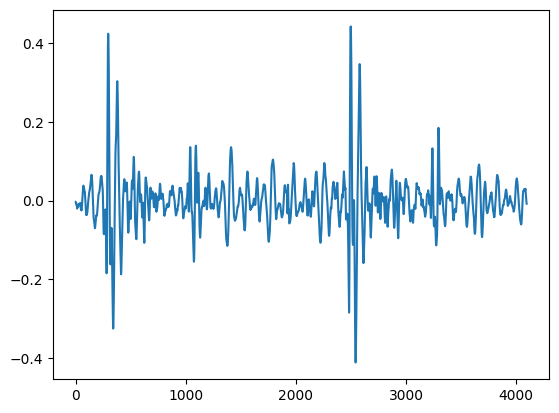

In [8]:
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

Fs = 4000 # Sampling frequency
i = random.randint(0, n-1)
x_test_original = xs_test[i]
x_test = x_test_original.clone()
plt.plot(x_test)
audio_input = x_test.cpu().detach().numpy()  # Convert to numpy array for audio playback
#audio_input= interpolate_audio(torch.tensor(audio_input), multiplier=2)  # Interpolate to a longer length
Audio(data=audio_input, rate=Fs)

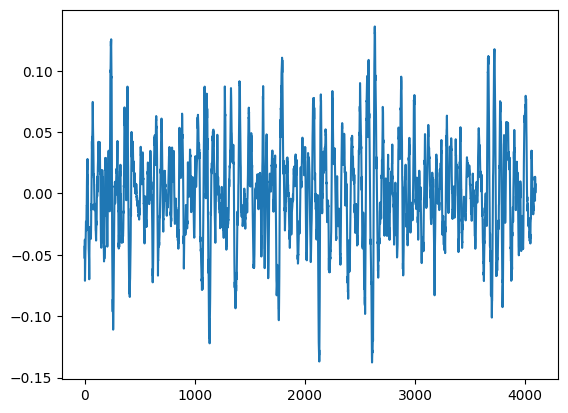

In [9]:
model_name = "cvae"
model = models[model_name]  # Change to the model you want to use for reconstruction
x_test = x_test_original.clone()
x_test = x_test.unsqueeze(0).to(device)  # Add batch dimension
x_test = x_test.unsqueeze(0)  # Add channel dimension for CAE
x_rec = model(x_test)
if "v" in model_name:
    x_rec = x_rec[0]
x_rec = x_rec.squeeze(0).squeeze(0).cpu().detach().numpy()  # Remove batch and channel dimensions
plt.plot(x_rec)
Audio(data=x_rec, rate=Fs)

In [10]:
models_variational = {model_name: model for model_name, model in models.items() if "v" in model_name}
models_variational.keys()

dict_keys(['vae', 'cvae'])

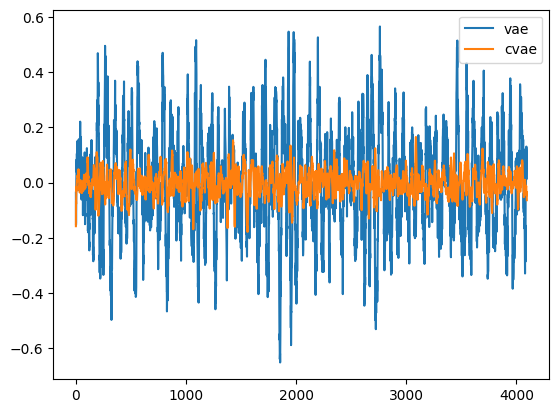

In [17]:
fig = plt.figure()
generated_signal = {}
for model_name, model in models_variational.items():
    generated = model.sample(1, device)
    generated = generated.cpu().detach().numpy()
    generated = generated.flatten()
    generated_signal[model_name] = generated
    plt.plot(generated, label = model_name)
plt.legend()

In [21]:
#for model_name, model in models_variational.items():
generated = generated_signal["vae"]
Audio(data=generated, rate=Fs)

In [22]:
generated = generated_signal["cvae"]
Audio(data=generated, rate=Fs)

In [24]:
generated = generated_signal["kvae"]
Audio(data=generated, rate=Fs)

KeyError: 'kvae'

In [23]:
generated = generated_signal["kcvae"]
Audio(data=generated, rate=Fs)

KeyError: 'kcvae'